In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
#from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [3]:
#!pip install pmdarima

In [65]:
#data = pd.read_csv('../dataset/NFA.Canada.csv')
data = pd.read_csv('NFA.Canada.csv')

In [5]:
data.columns

Index(['country', 'year', 'record_x', 'TOT_EF', 'Continent', 'record_y', 'TOT_Biocapacity', 'Biocapacity_Res_Def'], dtype='object')

In [70]:
data = data.drop(['country', 'record_x', 'TOT_EF', 'Continent', 'record_y', 'TOT_Biocapacity'], axis=1)
data

,year,Biocapacity_Res_Def
0,1991-01-01,295909528.500
1,1992-01-01,293857007.900
2,1993-01-01,293119288.800
3,1994-01-01,301985161.200
4,1995-01-01,289815112.700
5,1996-01-01,283188617.300
6,1997-01-01,276221733.100
7,1998-01-01,283579904.300
8,1999-01-01,271143525.700
9,2000-01-01,261994691.700


In [71]:
print('Time period start: {}\nTime period end: {}'.format(data.year.min(),data.year.max()))

Time period start: 1991-01-01 00:00:00
Time period end: 2016-01-01 00:00:00


In [72]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year                 26 non-null     datetime64[ns]
 1   Biocapacity_Res_Def  26 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 544.0 bytes


In [73]:
data['year'] = pd.to_datetime(data['year'], format='%Y')
data.year

0    1991-01-01
1    1992-01-01
2    1993-01-01
3    1994-01-01
4    1995-01-01
5    1996-01-01
6    1997-01-01
7    1998-01-01
8    1999-01-01
9    2000-01-01
10   2001-01-01
11   2002-01-01
12   2003-01-01
13   2004-01-01
14   2005-01-01
15   2006-01-01
16   2007-01-01
17   2008-01-01
18   2009-01-01
19   2010-01-01
20   2011-01-01
21   2012-01-01
22   2013-01-01
23   2014-01-01
24   2015-01-01
25   2016-01-01
Name: year, dtype: datetime64[ns]

**Setting index as the datetime column for easier manipulations:**

In [74]:
y = data.set_index('year')
y

,Biocapacity_Res_Def
year,
1991-01-01,295909528.500
1992-01-01,293857007.900
1993-01-01,293119288.800
1994-01-01,301985161.200
1995-01-01,289815112.700
1996-01-01,283188617.300
1997-01-01,276221733.100
1998-01-01,283579904.300
1999-01-01,271143525.700


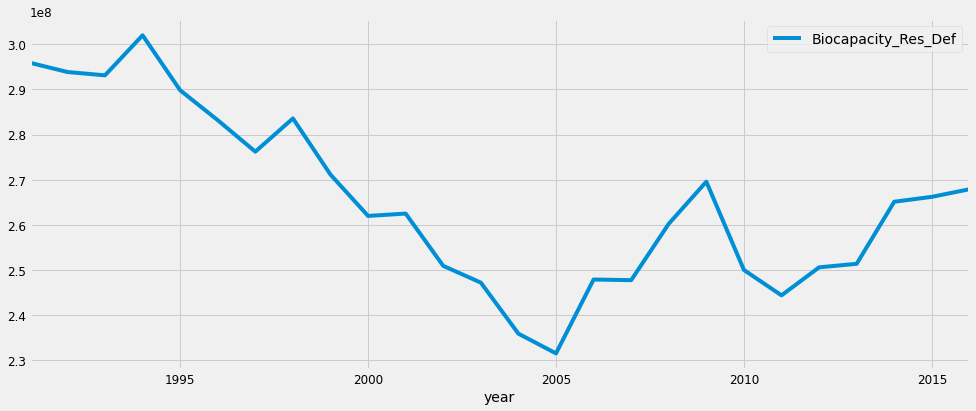

In [75]:
y.plot(figsize=(15, 6))
plt.show()

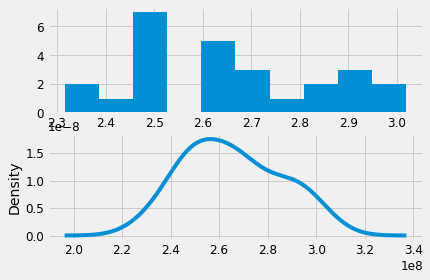

In [76]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.Biocapacity_Res_Def.hist()
pyplot.subplot(212)
y.Biocapacity_Res_Def.plot(kind='kde')
pyplot.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

# Decomposition of the time series data

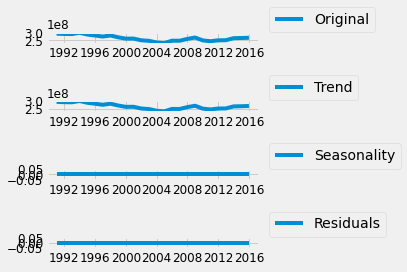

In [181]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc=(1.05, 1))

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc=(1.05, 1))

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc=(1.05, 1))

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc=(1.05, 1))
plt.tight_layout()

# Stationarity


- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

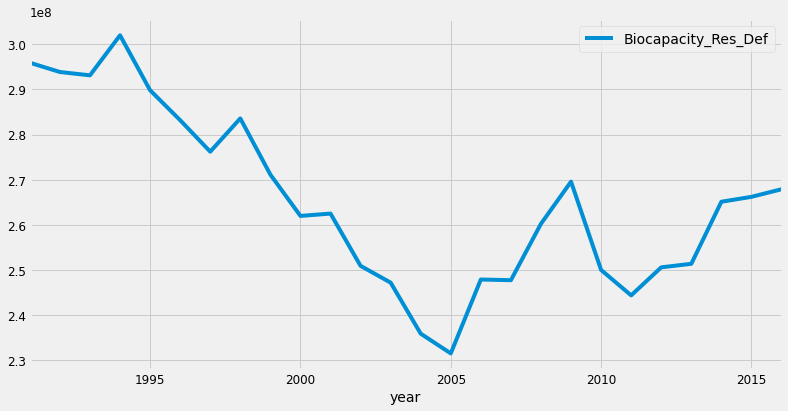

In [168]:
y.plot(figsize=(12, 6))
plt.show()

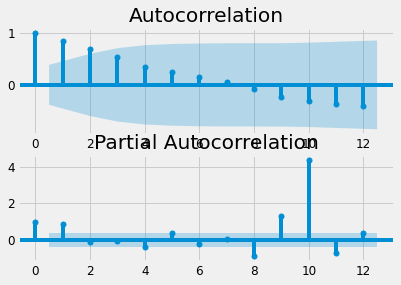

In [83]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.Biocapacity_Res_Def, ax=pyplot.gca(), lags = 12)
pyplot.subplot(212)
plot_pacf(y.Biocapacity_Res_Def, ax=pyplot.gca(), lags = 12)
pyplot.show()

## Plotting Rolling Statistics
The most basic approach for understanding this is to plot the data and check if there’s any hint at the presence of underlying trends or seasonality. This visual practice rarely helps and often its difficult for the human eye to tell this. So we can add rolling statistics (like moving average, rolling std etc) to the data with a fixed window size to check for stationarity

In [ ]:
y

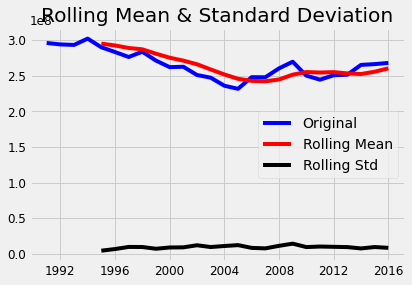

In [170]:
#Determing rolling statistics
rolmean = y.rolling(5).mean()
rolstd = y.rolling(5).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

- We observe that the rolling mean and Standard deviation are not constant with respect to time (decreasing trend)
- The time series is hence not stationary

##  Augmented Dickey-Fuller Test

The `Augmented Dickey Fuller Test (ADF)` is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.

The Augmented Dickey-Fuller test can be used with serial correlation. Steps to follow:

- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate stationarity

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [171]:
from statsmodels.tsa.stattools import adfuller

In [183]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y)
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value',
                            '#Lags Used','Number of Observations Used'])
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -2.012
p-value                        0.281
#Lags Used                     8.000
Number of Observations Used   17.000
dtype: float64


# Time Series modelling 
## Autoregression (AR)

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.

`Autoregressive` models are based on the idea that current value of the series, Xt, can be explained as a linear combination of n past values

Xt−1, Xt−2, . . . , Xt−p, 

together with a random error in the same series


- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [46]:
from statsmodels.tsa.ar_model import AR
from random import random

In [184]:
# fit model
model = AR(y)
model_fit = model.fit()

In [185]:
model_fit.fittedvalues

year
2000-01-01   255872829.315
2001-01-01   261690644.690
2002-01-01   251083142.351
2003-01-01   246745240.570
2004-01-01   247471589.208
2005-01-01   235520497.258
2006-01-01   244985573.684
2007-01-01   247302602.732
2008-01-01   251916288.041
2009-01-01   266113404.064
2010-01-01   255651659.637
2011-01-01   250297914.335
2012-01-01   242055210.715
2013-01-01   251230283.668
2014-01-01   267456497.974
2015-01-01   269925463.886
2016-01-01   266063746.172
dtype: float64

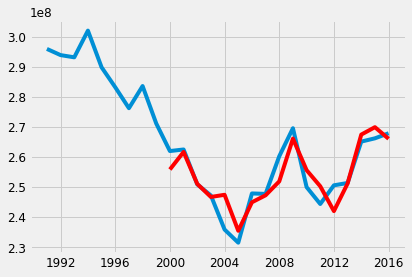

In [153]:
plt.plot(y)
plt.plot(model_fit.fittedvalues, color='red')
plt.show()

### Forecast over a period of time

In [218]:
from datetime import datetime
forecast_ar = model_fit.predict(start=datetime(2016, 1, 1), end=datetime(2028,12,31))

In [219]:
forecast_ar

2016-01-01   266063746.172
2017-01-01   267488342.482
2018-01-01   249755677.410
2019-01-01   249509701.182
2020-01-01   254650066.282
2021-01-01   255926164.078
2022-01-01   268559841.345
2023-01-01   266912866.311
2024-01-01   260879698.516
2025-01-01   257265364.727
2026-01-01   244757841.957
2027-01-01   248503592.806
2028-01-01   256719099.496
2029-01-01   259586258.518
Freq: AS-JAN, dtype: float64

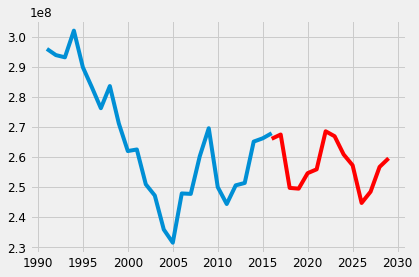

In [220]:
plt.plot(y)
plt.plot(forecast_ar, color='red')
plt.show()

## ARIMA

    No acaba de ajustarse muy bien este modelo

In [156]:
y

,Biocapacity_Res_Def
year,
1991-01-01,295909528.500
1992-01-01,293857007.900
1993-01-01,293119288.800
1994-01-01,301985161.200
1995-01-01,289815112.700
1996-01-01,283188617.300
1997-01-01,276221733.100
1998-01-01,283579904.300
1999-01-01,271143525.700


In [157]:
#divide into train and validation set
train = y[:-4]
valid = y[-4:]

#plotting the data
#train.plot()
valid

,Biocapacity_Res_Def
year,
2013-01-01,251396171.000
2014-01-01,265134434.900
2015-01-01,266218998.300
2016-01-01,267900623.100


In [221]:
#building the model
from pmdarima import auto_arima
model_arima = auto_arima(y, trace=True, error_action='ignore', 
                   suppress_warnings=True)
model_arima.fit(y)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=875.715, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=877.728, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=877.802, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=874.117, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=878.597, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.318 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [228]:
forecast_ari = model_arima.predict(start=datetime(2016, 1, 1), 
                                   end=datetime(2028,12,31))
forecast_ari = pd.DataFrame(forecast,columns=['Prediction'], 
                            index = forecast_ar.index[:10])
forecast_ari

,Prediction
2016-01-01,267900623.100
2017-01-01,267900623.100
2018-01-01,267900623.100
2019-01-01,267900623.100
2020-01-01,267900623.100
2021-01-01,267900623.100
2022-01-01,267900623.100
2023-01-01,267900623.100
2024-01-01,267900623.100
2025-01-01,267900623.100


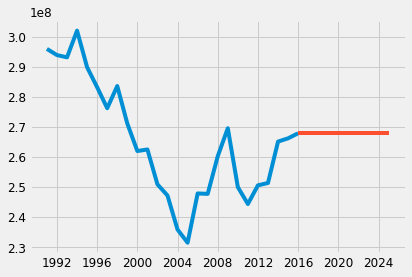

In [230]:
#plot the predictions for validation set
plt.plot(y, label='Valid')
plt.plot(forecast_ari, label='Prediction')
plt.show()

In [ ]:
###########################################################################
############ FIN Idoia ####################################################

In [ ]:
r2_score(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
mean_absolute_error(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
median_absolute_error(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
mean_squared_error(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
mean_squared_log_error(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [ ]:
evaluate_forecast(y.Biocapacity_Res_Def, predictions_AR)

In [ ]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [ ]:
model_fit.summary()

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

In [ ]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(2, 1))
model_fit = model.fit(disp=False)

In [ ]:
model_fit.summary()

In [ ]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

In [ ]:
ts = y.Biocapacity_Res_Def - y.Biocapacity_Res_Def.shift()
ts.dropna(inplace=True)

In [ ]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=13)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=13)
pyplot.show()

In [ ]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['Biocapacity_Res_Def'].plot()
valid['Biocapacity_Res_Def'].plot()

In [ ]:
model = ARIMA(train, order=(1,0,0))
results_ARIMA = model.fit(disp=1)

In [ ]:
model_fit.summary()

In [ ]:
valid

In [ ]:
start_index = valid.index.min()

end_index = valid.index.max()
start_index

In [ ]:
#Predictions
predictions = model_fit.predict(start=valid.index.min(), end=valid.index.max())

In [ ]:
start_index

In [ ]:
type(start_index)

In [ ]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

In [ ]:
plt.plot(y.Biocapacity_Res_Def)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

In [ ]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

In [ ]:
predictions_ARIMA_log = pd.Series(valid.Biocapacity_Res_Def.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
plt.plot(y.Biocapacity_Res_Def)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [ ]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

In [ ]:
#building the model
from pmdarima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.Biocapacity_Res_Def, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [ ]:
evaluate_forecast(valid, forecast)

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)